In [12]:
import os
os.chdir('/home/soham/Desktop/GitHub/BTP/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [13]:
mix_111_sensor1 = pd.read_excel('data/time_data/ratio_111/Sensor 1_111.xlsx')
mix_111_sensor2 = pd.read_excel('data/time_data/ratio_111/Sensor 2_111.xlsx')
mix_111_sensor3 = pd.read_excel('data/time_data/ratio_111/Sensor 3_111.xlsx')

mix_111 = pd.DataFrame()
mix_111['Dilution'] = mix_111_sensor1['Dilutions']
mix_111['Sensor1'] = mix_111_sensor1['Voltage sensor1_111']
mix_111['Sensor2'] = mix_111_sensor2['Voltage_sensor2_111']
mix_111['Sensor3'] = mix_111_sensor3['Voltage _sensor3_111']
mix_111['Label'] = ['Mix_111' for i in range(len(mix_111))]
mix_111 = mix_111[['Dilution','Sensor1','Sensor2','Sensor3','Label']]

analyte1 = pd.read_csv('data/unsampled/Unsampled_Analyte1.csv').drop(['CFU/mL'], axis=1)
analyte2 = pd.read_csv('data/unsampled/Unsampled_Analyte2.csv').drop(['CFU/mL'], axis=1)
analyte3 = pd.read_csv('data/unsampled/Unsampled_Analyte3.csv').drop(['CFU/mL'], axis=1)

analyte1['Dilution'] = mix_111['Dilution']
analyte1['Label'] = ['A1' for i in range(len(analyte1))]

analyte2['Dilution'] = mix_111['Dilution'] 
analyte2['Label'] = ['A2' for i in range(len(analyte2))]

analyte3['Dilution'] = mix_111['Dilution']
analyte3['Label'] = ['A3' for i in range(len(analyte3))]

analyte1 = analyte1[['Dilution','Sensor1','Sensor2','Sensor3','Label']]
analyte2 = analyte2[['Dilution','Sensor1','Sensor2','Sensor3','Label']]
analyte3 = analyte3[['Dilution','Sensor1','Sensor2','Sensor3','Label']]


mix_101 = pd.read_excel('data/time_data/ratio_101/all_sensors_101.xlsx').drop(['Dilutions'],axis=1)
mix_101['Sensor1'] = mix_101['Voltage _sensor1_analyte1_analyte3(1:1)']
mix_101['Sensor2'] = mix_101['Voltage _sensor2_analyte1_analyte3(1:1)']
mix_101['Sensor3'] = mix_101['Voltage _sensor3_analyte1_analyte3(1:1)']
mix_101 = mix_101.drop(['Voltage _sensor1_analyte1_analyte3(1:1)','Voltage _sensor2_analyte1_analyte3(1:1)','Voltage _sensor3_analyte1_analyte3(1:1)'], axis=1)
mix_101['Dilution'] = mix_111['Dilution']
mix_101['Label'] = ['Mix_101' for i in range(len(mix_101))]
mix_101 = mix_101[['Dilution','Sensor1','Sensor2','Sensor3','Label']]


total_new_data = pd.concat([analyte1, analyte2, analyte3, mix_111, mix_101], axis=0).reset_index(drop=True)

total_new_data.to_csv('data/mixture/total_new_data(5 mixtures).csv', index=False)
total_new_data.to_excel('data/mixture/total_new_data(5 mixtures).xlsx', index=False)

del analyte1, analyte2, analyte3, mix_111, mix_101, mix_111_sensor1, mix_111_sensor2, mix_111_sensor3

### PCA  

In [14]:
total_new_data = total_new_data.drop(['Dilution'], axis=1)
labels = total_new_data['Label']
labels = labels.map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})

total_new_data.head()

,Sensor1,Sensor2,Sensor3,Label
0,-68.02,70.734,52.47,A1
1,-95.70,50.162,32.63,A1
2,-99.96,-8.390,-10.41,A1
3,-107.42,-18.700,-23.93,A1
4,-109.94,-19.620,-27.24,A1


In [15]:
X = total_new_data[['Sensor1','Sensor2','Sensor3']]
Y = total_new_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})

pca  = PCA(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])

X_train, X_test, Y_train, Y_test = train_test_split(pca_data, Y, test_size=0.2, random_state=np.random.randint(0,100))

pca_data.head()

,PC1,PC2
0,-55.202860,81.835563
1,-88.932533,61.649759
2,-109.967696,-6.291737
3,-121.811320,-20.589443
4,-125.253201,-22.830231


### SVM on 5 Classes

Training accuracy =  0.875
Testing accuracy =  0.9


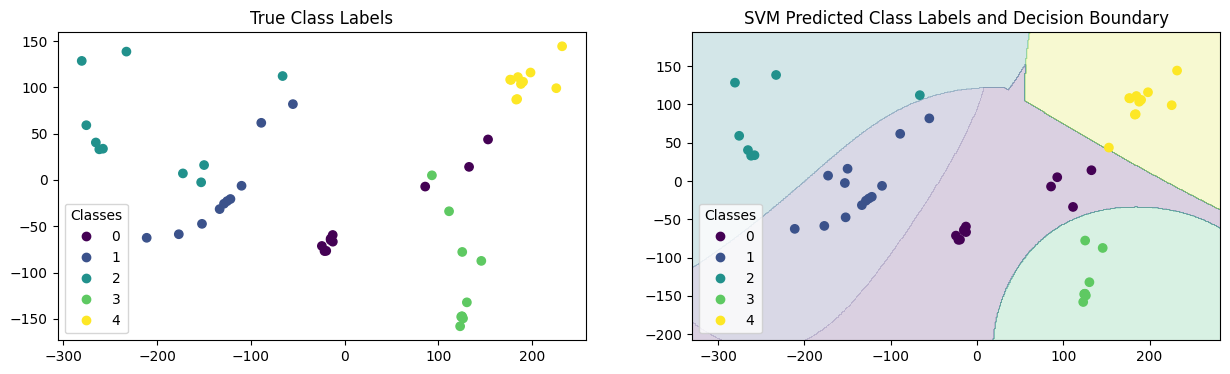

In [16]:
svm = SVC(kernel='rbf')
svm.fit(X_train, Y_train)

print('Training accuracy = ', svm.score(X_train, Y_train))

pred = svm.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))


predictions = svm.predict(pca_data)

x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = svm.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
Z = Z.reshape(xx.shape)



# PLOTTING THE DECISION BOUNDARY 

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
scatter = ax[0].scatter(pca_data['PC1'], pca_data['PC2'], c=Y, cmap='viridis')
legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].set_title('True Class Labels')

ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
scatter = ax[1].scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].set_title('SVM Predicted Class Labels and Decision Boundary')

plt.show()

### Random Forest

Training accuracy =  1.0
Testing accuracy =  0.9


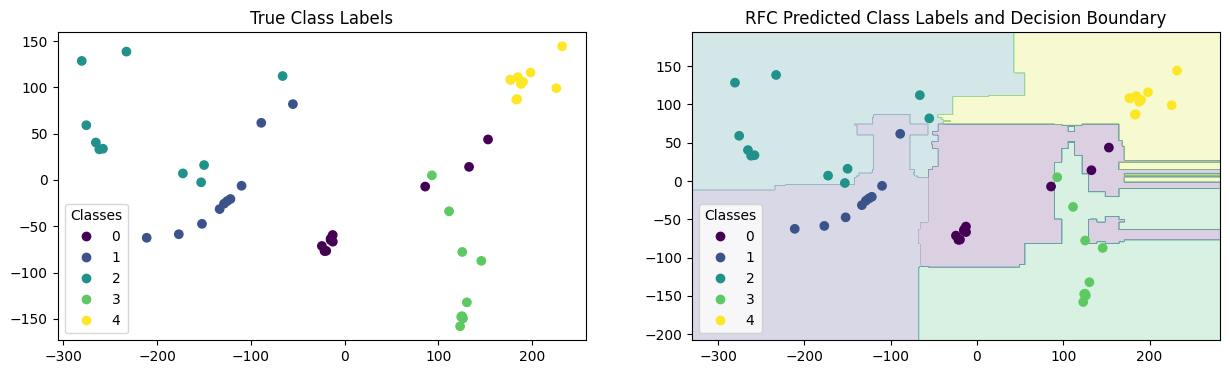

In [17]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)

print('Training accuracy = ', rfc.score(X_train, Y_train))

pred = rfc.predict(X_test)
print('Testing accuracy = ', accuracy_score(Y_test, pred))


predictions = rfc.predict(pca_data)

x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = rfc.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
Z = Z.reshape(xx.shape)


# PLOTTING THE DECISION BOUNDARY 

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
scatter = ax[0].scatter(pca_data['PC1'], pca_data['PC2'], c=Y, cmap='viridis')
legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")
ax[0].set_title('True Class Labels')

ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
scatter = ax[1].scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].set_title('RFC Predicted Class Labels and Decision Boundary')

plt.show()

## Additional Noise Points

In [18]:
def add_noise(data, labels, noise_level, target_size=350):
    combined_data = data.copy()
    combined_labels = labels.copy()

    while len(combined_data) < target_size:
        noisy_data = data.copy()
        new_data_points = []

        for sensor in ['Sensor1', 'Sensor2', 'Sensor3']:
            noise = np.random.uniform(-noise_level, noise_level, size=noisy_data.shape[0])
            new_data = noisy_data[sensor] + (noisy_data[sensor] * noise)
            new_data_points.append(new_data)

        new_data_df = pd.DataFrame({
            'Sensor1': new_data_points[0],
            'Sensor2': new_data_points[1],
            'Sensor3': new_data_points[2]
        })
        new_labels = labels.copy()

        combined_data = pd.concat([combined_data, new_data_df], ignore_index=True)
        combined_labels = pd.concat([combined_labels, new_labels], ignore_index=True)

    combined_data = combined_data.iloc[:target_size]
    combined_labels = combined_labels.iloc[:target_size]

    return combined_data, combined_labels

Noise Level: 0.05
Training accuracy =  0.9571428571428572
Testing accuracy =  0.9428571428571428


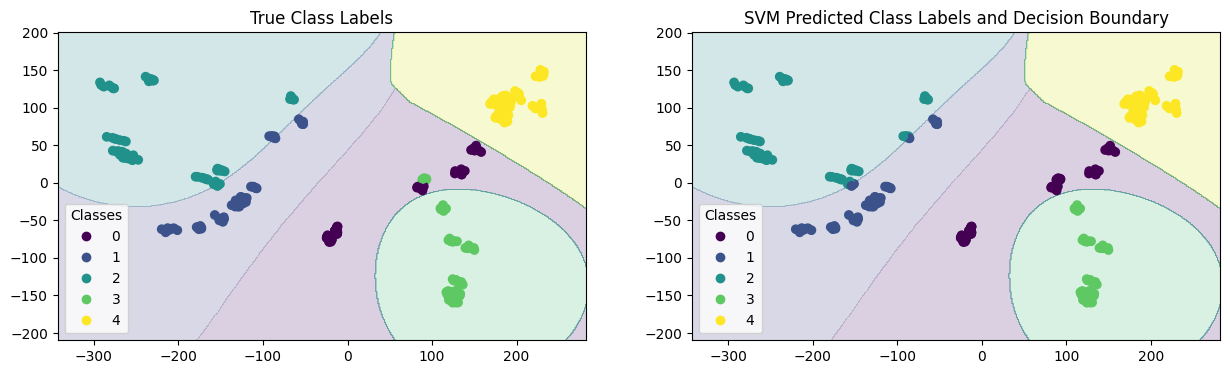

Noise Level: 0.1
Training accuracy =  0.9392857142857143
Testing accuracy =  0.9571428571428572


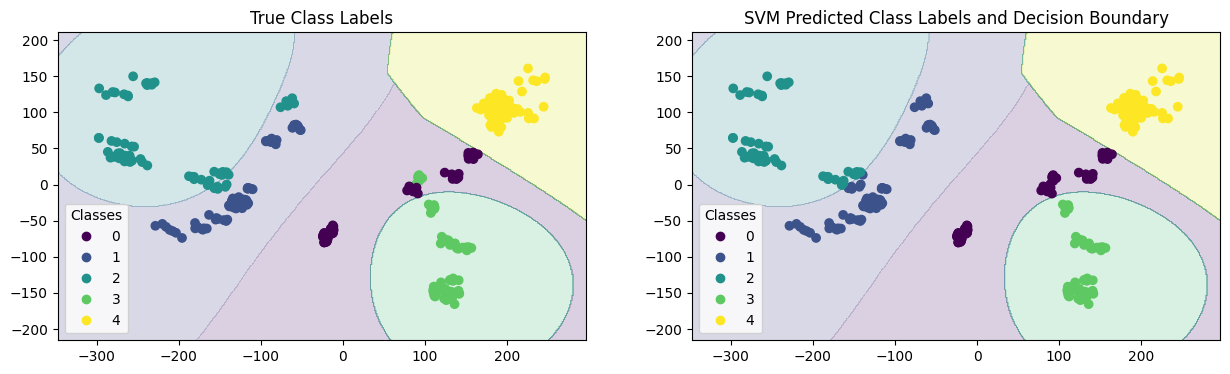

Noise Level: 0.15
Training accuracy =  0.9357142857142857
Testing accuracy =  0.9857142857142858


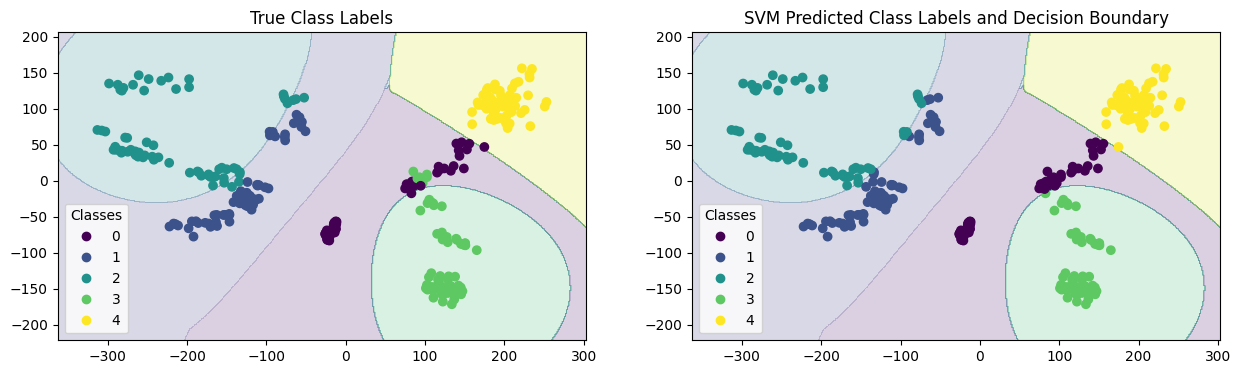

Noise Level: 0.2
Training accuracy =  0.9428571428571428
Testing accuracy =  0.9


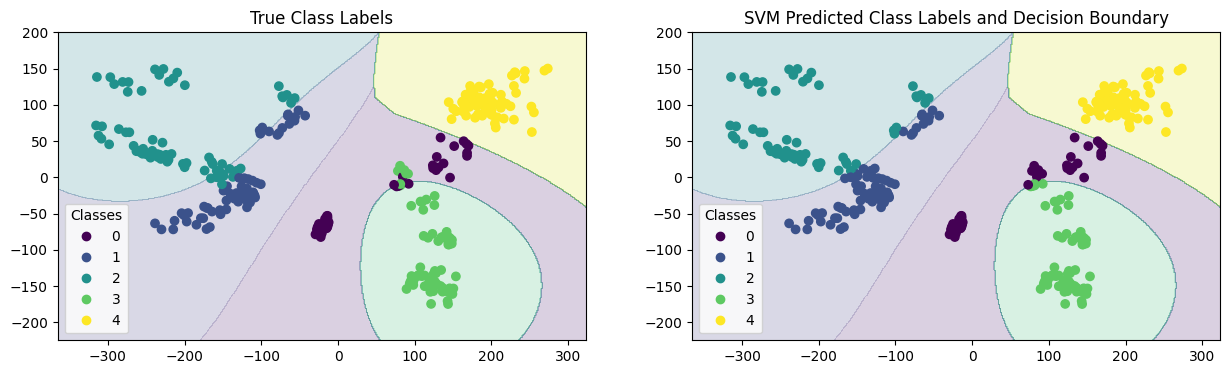

Noise Level: 0.25
Training accuracy =  0.9142857142857143
Testing accuracy =  0.9142857142857143


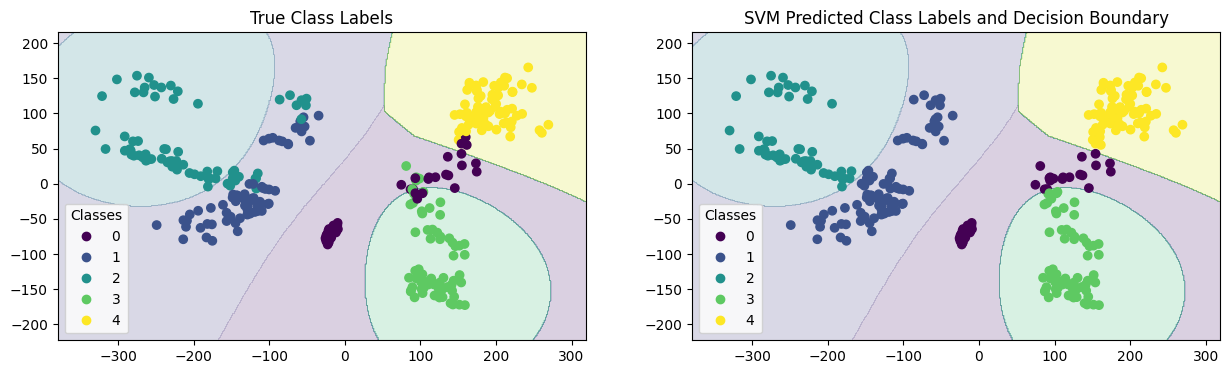

In [19]:
for p in [0.05, 0.10, 0.15, 0.2, 0.25]:

    # Adding noise to the data

    print(f'Noise Level: {p}')
    data_noisy, noisy_labels = add_noise(total_new_data[['Sensor1', 'Sensor2', 'Sensor3']], total_new_data['Label'], p)


    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data_noisy)
    pca_data = pd.DataFrame(pca_data, columns=['PC1','PC2'])
    pca_data['Label'] = noisy_labels


    # Split into training and testing data

    Y = pca_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})
    X = pca_data.drop(['Label'], axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0,100))

    svm = SVC(kernel='rbf')
    svm.fit(X_train, Y_train)
    print('Training accuracy = ', svm.score(X_train, Y_train))

    pred = svm.predict(X_test)
    print('Testing accuracy = ', accuracy_score(Y_test, pred))

    # Plotting

    predictions = svm.predict(X)

    x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
    y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = svm.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
    Z = Z.reshape(xx.shape)

    # PLOTTING THE DECISION BOUNDARY 

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[0].scatter(pca_data['PC1'], pca_data['PC2'], c=Y, cmap='viridis')
    legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")
    ax[0].set_title('True Class Labels')

    ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[1].scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
    legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
    ax[1].set_title('SVM Predicted Class Labels and Decision Boundary')
    
    plt.show()

### Random Forest

Noise Level: 0.05
Training accuracy =  1.0
Testing accuracy =  1.0


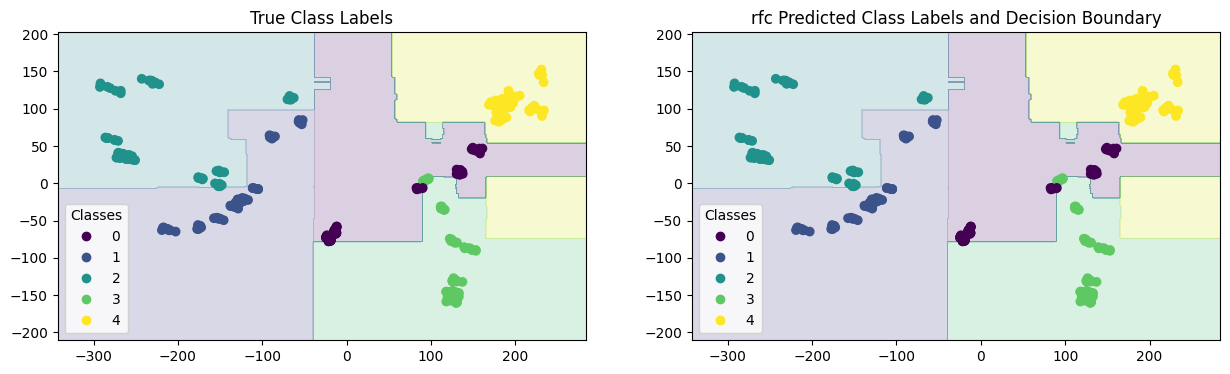

Noise Level: 0.1
Training accuracy =  1.0
Testing accuracy =  0.9857142857142858


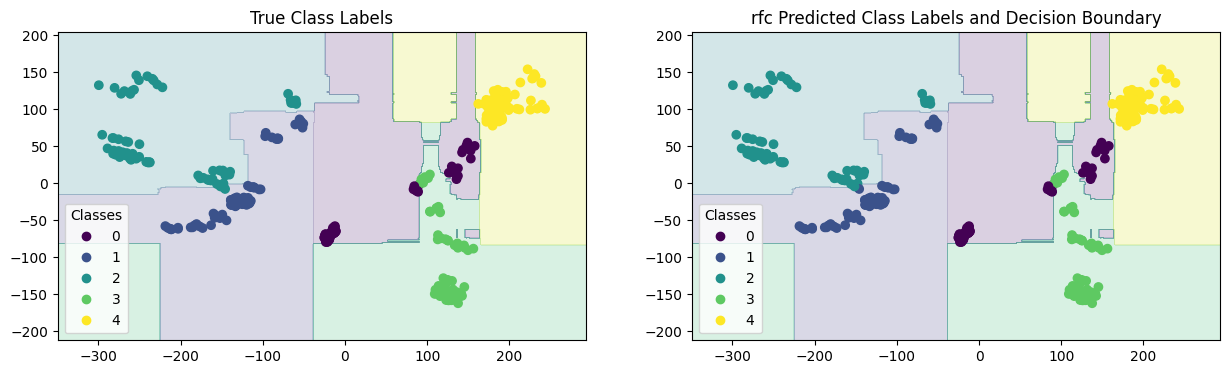

Noise Level: 0.15
Training accuracy =  1.0
Testing accuracy =  0.9571428571428572


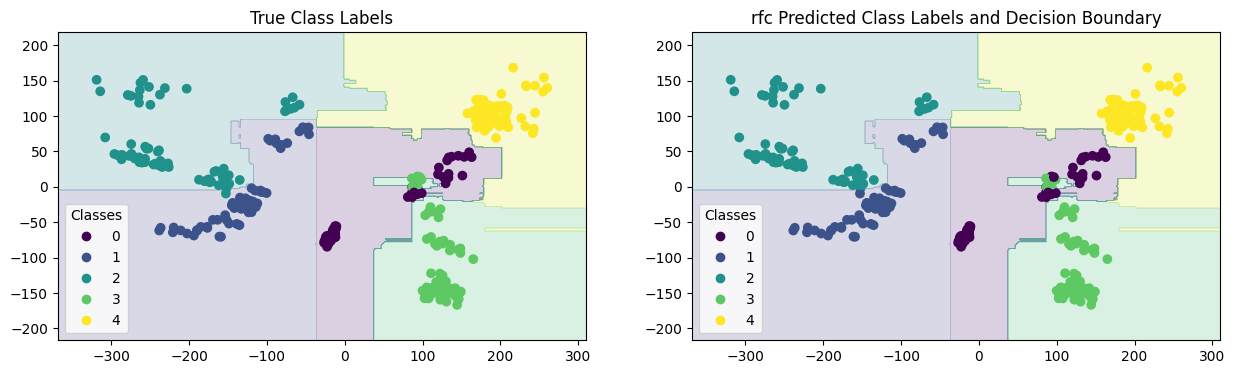

Noise Level: 0.2
Training accuracy =  1.0
Testing accuracy =  0.9428571428571428


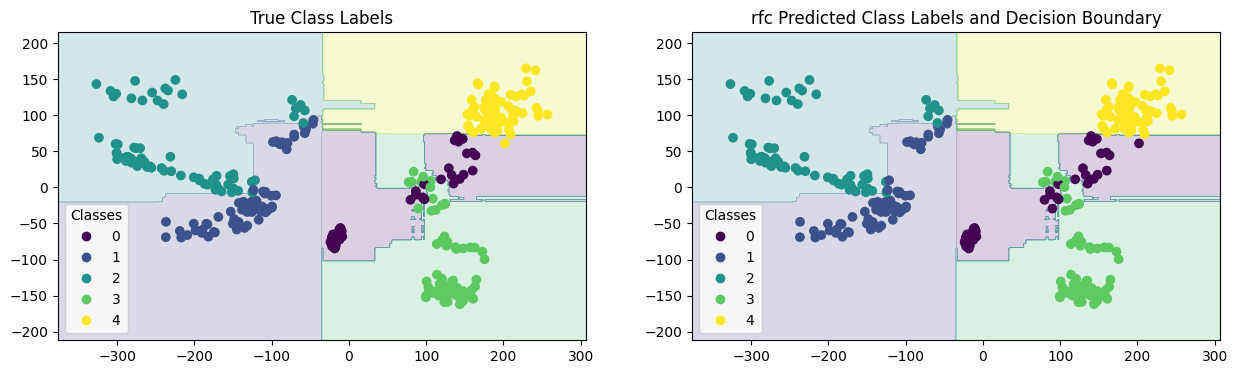

Noise Level: 0.25
Training accuracy =  1.0
Testing accuracy =  0.9142857142857143


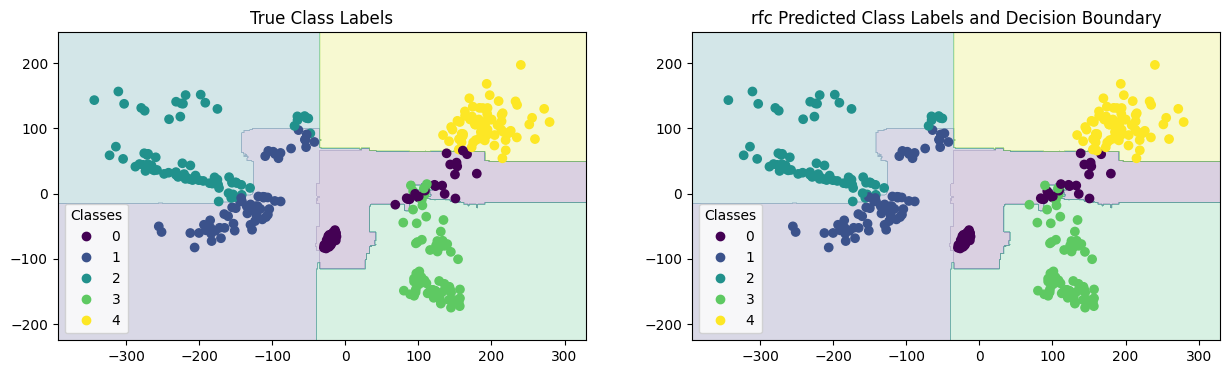

In [20]:
for p in [0.05, 0.10, 0.15, 0.2, 0.25]:

    # Adding noise to the data

    print(f'Noise Level: {p}')
    data_noisy, noisy_labels = add_noise(total_new_data[['Sensor1', 'Sensor2', 'Sensor3']], total_new_data['Label'], p)


    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data_noisy)
    pca_data = pd.DataFrame(pca_data, columns=['PC1','PC2'])
    pca_data['Label'] = noisy_labels


    # Split into training and testing data

    Y = pca_data['Label'].map({'Mix_101': 0, 'A1': 1, 'A2': 2, 'A3': 3, 'Mix_111':4})
    X = pca_data.drop(['Label'], axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=np.random.randint(0,100))

    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X_train, Y_train)
    print('Training accuracy = ', rfc.score(X_train, Y_train))

    pred = rfc.predict(X_test)
    print('Testing accuracy = ', accuracy_score(Y_test, pred))

    # Plotting

    predictions = rfc.predict(X)

    x_min, x_max = pca_data['PC1'].min() - 50, pca_data['PC1'].max() + 50
    y_min, y_max = pca_data['PC2'].min() - 50, pca_data['PC2'].max() + 50
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    Z = rfc.predict(np.c_[xx.ravel().astype(float), yy.ravel().astype(float)])
    Z = Z.reshape(xx.shape)

    # PLOTTING THE DECISION BOUNDARY 

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ax[0].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[0].scatter(pca_data['PC1'], pca_data['PC2'], c=Y, cmap='viridis')
    legend0 = ax[0].legend(*scatter.legend_elements(), title="Classes")
    ax[0].set_title('True Class Labels')

    ax[1].contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    scatter = ax[1].scatter(pca_data['PC1'], pca_data['PC2'], c=predictions, cmap='viridis')
    legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
    ax[1].set_title('rfc Predicted Class Labels and Decision Boundary')
    
    plt.show()